# Analysis tools

Before we start, we create an atmospheric setup case based on the ["Getting Started"](./getting_started.ipynb) example:

First setting up a `Radtrans` object:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from petitRADTRANS import physical_constants as cst
from petitRADTRANS.radtrans import Radtrans

atmosphere = Radtrans(
    pressures=np.logspace(-6, 3, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na__Burrows',
        'K__Burrows'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 15]
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na__Burrows' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Burrows.R1000_0.1-25

<div class="alert alert-warning">

**Units in petitRADTRANS:** all units inside *petitRADTRANS* are in cgs. However, when interfacing with the code, you are expected to provide pressures in bars (more intuitive). Pressures will be converted to cgs units within the code.
</div>

And the atmospheric parameters:

In [2]:
from petitRADTRANS.physics import temperature_profile_function_guillot_global

planet_radius = 1 * cst.r_jup_mean
reference_gravity = 10 ** 3.5
reference_pressure = 0.01

pressures = atmosphere.pressures * 1e-6 # cgs to bar
infrared_mean_opacity = 0.01
gamma = 0.4
intrinsic_temperature = 200
equilibrium_temperature = 1500

temperatures = temperature_profile_function_guillot_global(
    pressures=pressures, 
    infrared_mean_opacity=infrared_mean_opacity, 
    gamma=gamma, 
    gravities=reference_gravity, 
    intrinsic_temperature=intrinsic_temperature, 
    equilibrium_temperature=equilibrium_temperature
)

mass_fractions = {
    'H2': 0.74 * np.ones(temperatures.size), 
    'He': 0.24 * np.ones(temperatures.size),
    'H2O': 1e-3 * np.ones(temperatures.size), 
    'CO-NatAbund': 1e-2 * np.ones(temperatures.size),
    'CO2': 1e-4 * np.ones(temperatures.size), 
    'CH4': 1e-5 * np.ones(temperatures.size),
    'Na__Burrows': 1e-4 * np.ones(temperatures.size), 
    'K__Burrows': 1e-6 * np.ones(temperatures.size)
}

#  2.33 is a typical value for H2-He dominated atmospheres
mean_molar_masses = 2.33 * np.ones_like(temperatures)

<div class="alert alert-warning">

**Abundances in petitRADTRANS:** abundances in pRT are in units of **mass fractions**, not number fractions (aka volume mixing ratio, VMR). One can convert between mass fractions and VMRs by using
\begin{equation}
X_i = \frac{\mu_i}{\mu}n_i,
\end{equation}
where $X_i$ is the mass fraction of species $i$, $\mu_i$ the molar mass of a molecule/atom/ion/... of species $i$, $\mu$ is the atmospheric mean molar mass, and $n_i$ is the VMR of species $i$. This is implemented in `petitRADTRANS.chemistry.utils.mass_fractions2volume_mixing_ratios()` and `petitRADTRANS.chemistry.utils.volume_mixing_ratios2mass_fractions()`.

</div>

## Transmission contribution functions

We calculate the transmission spectrum in the usual way, this time setting the ``return_contribution = True`` keyword argument, however. This will additionally measure the contribution of the different layers, by calculating as many transmission spectra as there are layers, iteratively turning off the opacity in one layer only. The difference to the nominal transmission spectrum then measures the influence of the respective layers. Note that calculating the contribution function will increase the computation time considerably. The formal definition of the contribution function is [(Mollière et al. 2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract):

\begin{equation}
C_{\rm tr}^{i} = \frac{R_{\rm nom}^2-R^2(\kappa_i=0)}{\sum_{j=1}^{N_{\rm L}}\left[R_{\rm nom}^2-R^2(\kappa_j=0)\right]},
\end{equation}

where $R_{\rm nom}$ is the nominal transmission radius of the planet and $R(\kappa_i=0)$ is the transmission radius obtained from setting the opacity in the $i$th layer to zero. $N_{\rm L}$ is the number of atmospheric layers.

Now, to the contribution function calculation (this can take a couple of minutes):

In [3]:
%%time
wavelengths, transit_radii, additional_outputs = atmosphere.calculate_transit_radii(
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
    return_contribution=True
)

CPU times: user 2min 15s, sys: 4.87 s, total: 2min 20s
Wall time: 2min 13s


<div class="alert alert-info">

Transmission contribution functions can also be obtained with a `SpectralModel` object, using e.g.:
```python
spectral_model = SpectralModel(...)
spectral_model.model_parameters['return_contribution'] = True  # can also be set during the instantiation
wavelengths, transit_radii, additional_outputs = spectral_model.calculate_spectrum(
    mode='transmission',
    return_additional_outputs=True
)
```
</div>

The transmission contribution function is plotted below, one can see that pressures above ~1 bar (so altitudes below 1 bar) cannot be probed in the wavelength range studied here.

Text(0.5, 1.0, 'Transmission contribution function')

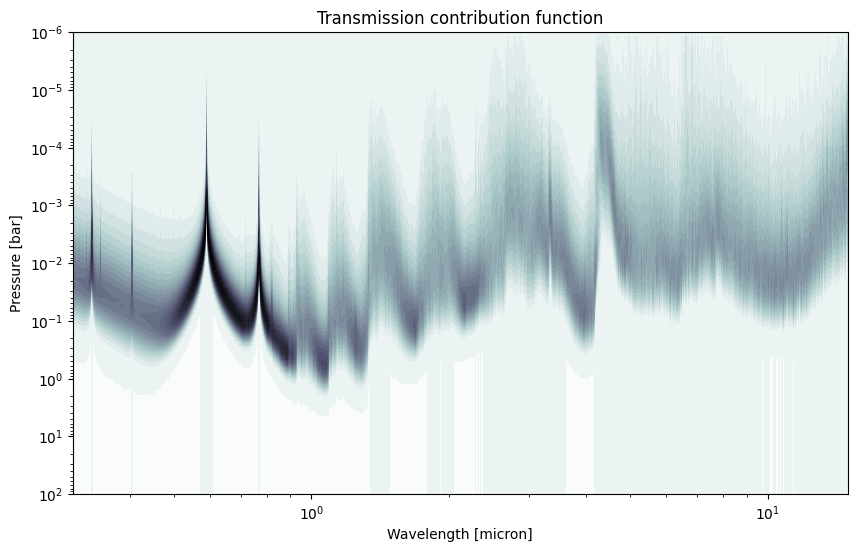

In [4]:
wavelengths_um = wavelengths * 1e4
x, y = np.meshgrid(wavelengths_um, pressures)

fig, ax = plt.subplots(figsize=(10, 6))
ax.contourf(x, y, additional_outputs['transmission_contribution'], 30, cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2, 1e-6])
ax.set_xlim([wavelengths_um[0], wavelengths_um[-1]])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Transmission contribution function')


## Emission contribution functions

Now we show the same for the emission contribution functions, which are defined in the usual way, that is, measuring the fraction of flux a layer contributes to the total flux, at a given wavelength (see, e.g., [Mollière et al. 2019](https://ui.adsabs.harvard.edu/abs/2019A%26A...627A..67M/abstract)). The computational time is comparable to a normal emission spectrum. To see the difference between the non-scattering (calculated here) and scattering emission contribution functions (calculated below), we will decrease the alkali opacities.

In [5]:
mass_fractions['Na'] = 1e-5 * np.ones_like(temperatures)
mass_fractions['K'] = 1e-7 * np.ones_like(temperatures)

wavelengths, flux, additional_outputs = atmosphere.calculate_flux(
    temperatures=temperatures,
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity,
    return_contribution=True
)

<div class="alert alert-info">

Emission contribution functions can also be obtained with a `SpectralModel` object, using e.g.:
```python
spectral_model = SpectralModel(...)
spectral_model.model_parameters['return_contribution'] = True  # can also be set during the instantiation
wavelengths, transit_radii, additional_outputs = spectral_model.calculate_spectrum(
    mode='emission',
    return_additional_outputs=True
)
```
</div>

The emission contribution function is plotted below, one can see that at the bluest wavelengths, pressures up to ~100 bar can be probed.

Text(0.5, 1.0, 'Emission contribution function')

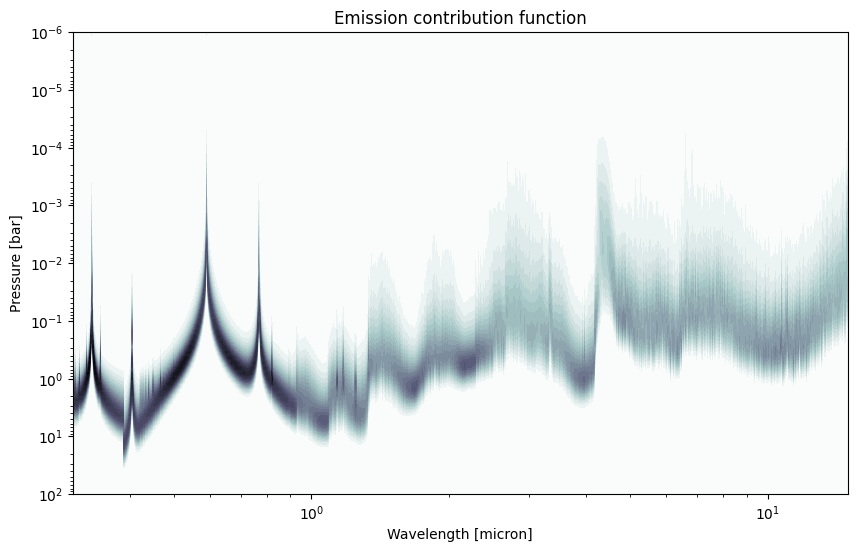

In [6]:
fig,ax = plt.subplots(figsize=(10,6))
ax.contourf(x, y, additional_outputs['emission_contribution'], 30, cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2,1e-6])
ax.set_xlim([np.min(wavelengths_um),np.max(wavelengths_um)])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Emission contribution function')

Already when comparing this emission contribution plot to the *transmission* case studied above one can see that scattering was not turned on here: in the transmission contribution plot, the Rayleigh scattering is clearly visible as an optical slope. Hence, we will turn on scattering in the emission spectrum calculation below to show its impact on the spectra.

<div class="alert alert-warning">

**Scattering and petitRADTRANS:** remember that scattering is included for emission spectra in petitRADTRANS only if requested specifically when generating the Radtrans object, as it increases the runtime (see ["Scattering for Emission Spectra"](./scattering_for_emission_spectra.ipynb) for an example how to do this).
</div>

First we reload the pRT object with scattering turned on:

In [7]:
atmosphere_scat = Radtrans(
    pressures=np.logspace(-6,3,100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na__Burrows',
        'K__Burrows'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    wavelength_boundaries=[0.3, 15],
    scattering_in_emission=True
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na__Burrows' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Burrows.R1000_0.1-25

Now we recalculate and plot the emission contribution function:

Text(0.5, 1.0, 'Emission contribution function')

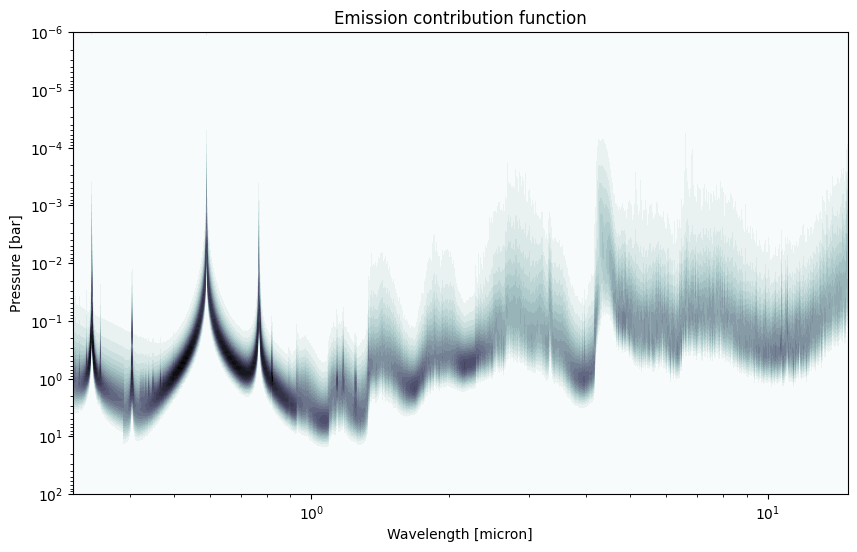

In [8]:
wavelengths, flux, additional_outputs = atmosphere_scat.calculate_flux(
    temperatures=temperatures,
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity,
    return_contribution=True
)

fig, ax = plt.subplots(figsize=(10,6))
ax.contourf(x, y, additional_outputs['emission_contribution'], 30, cmap=plt.cm.bone_r)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim([1e2,1e-6])
ax.set_xlim([np.min(wavelengths_um),np.max(wavelengths_um)])

ax.set_xlabel('Wavelength [micron]')
ax.set_ylabel('Pressure [bar]')
ax.set_title('Emission contribution function')

As can be seen, the Rayleigh scattering contribution to the emitted flux leaving the atmosphere is clearly visible now, with maximum probed pressures being in the range of 10, rather than 100 bar.

## Plotting opacity contributions

### Using `Radtrans`

In petitRADTRANS, it is possible to plot the opacity contributions of a spectrum using the `plot_opacity_contributions` function.

In [9]:
from petitRADTRANS.plotlib import plot_opacity_contributions

We can use the above transmission spectrum parameters.

Generating temporary Radtrans object with 'line_species': 'H2O'
Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CO-NatAbund'
Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully load

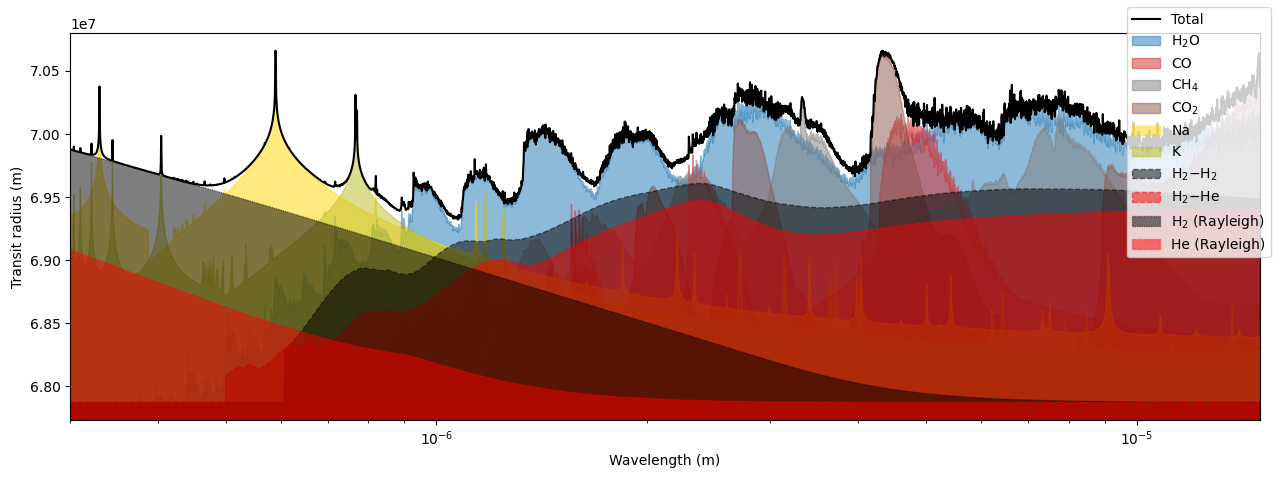

In [10]:
opacity_contributions = plot_opacity_contributions(
    atmosphere,
    mode='transmission',  # can also be 'emission'
    fill_below=True,  # if False, contributions are represented as cruves instead as a filled area
    x_axis_scale='log',  # 'linear' by default
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
)

 It is also possible to exclude some opacity sources from the plot. The output dictionary `opacity_contributions` can be used as input.

 <div class="alert alert-block alert-info">
    
The `opacity_contributions` directory can also be directly obtained from the `Radtrans` function `calculate_contribution_spectra`. That is, in this example, `atmosphere.calculate_contribution_spectra`.
</div>

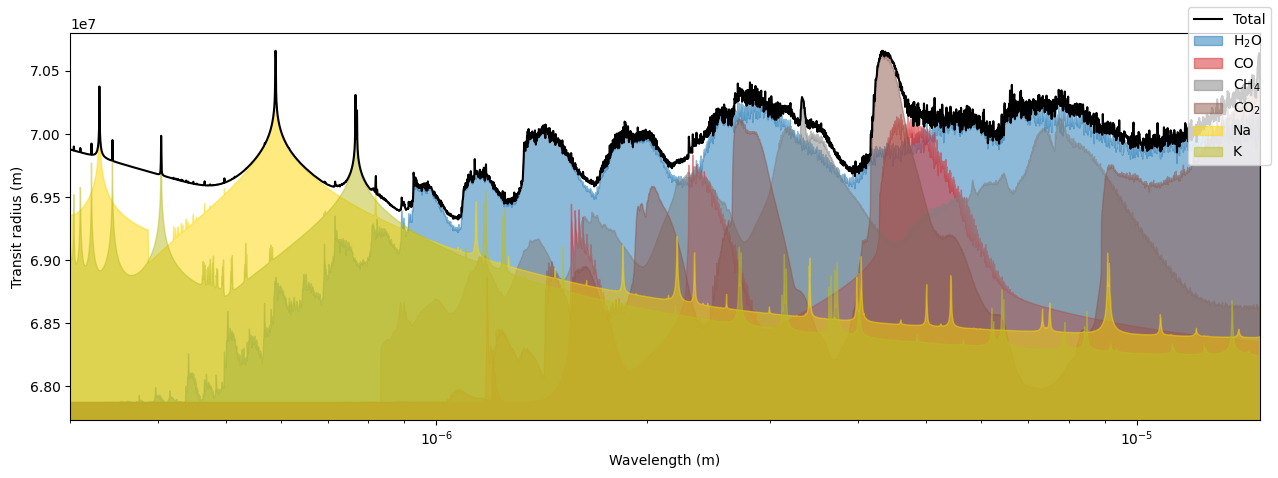

In [11]:
_ = plot_opacity_contributions(
    atmosphere,
    mode='transmission',
    exclude=['H2 (Rayleigh)', 'He (Rayleigh)', 'H2--H2', 'H2--He'],
    opacity_contributions=opacity_contributions,
    fill_below=True,
    x_axis_scale='log',
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
)

Finally, their is a possibility to plot only the desired species. Colors and linestyles can be customised as well.

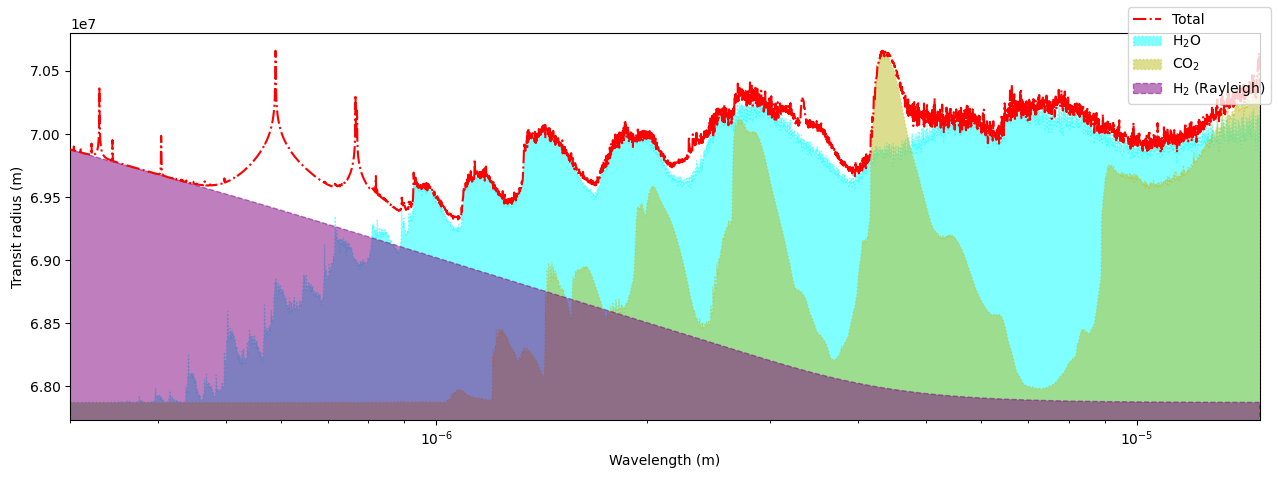

In [12]:
_ = plot_opacity_contributions(
    atmosphere,
    mode='transmission',
    include=['Total', 'H2O', 'CO2', 'H2 (Rayleigh)'],
    colors={
        'Total': 'r', 
        'line_species': {
            'H2O': 'aqua', 
            'CO2': '#bcbd22'
        }, 
        'rayleigh_species': {
            'H2': 'purple'
        }
    },
    line_styles={
        'Total': '-.', 
        'line_species': ':', 
        'rayleigh_species': '--'
    },
    opacity_contributions=opacity_contributions,
    fill_below=True,
    x_axis_scale='log',
    temperatures=temperatures, 
    mass_fractions=mass_fractions, 
    mean_molar_masses=mean_molar_masses, 
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure,
)

### Using `SpectralModel`

To obtain this contribution plot from an existing model, it may be more parctical to use a `SpectralModel`. In that case, the function does not need any parameter input, as they are taken from the `SpectralModel`'s model parameters.

In the following example, we will generate a `SpectralModel`, then plot its contribution.

In [13]:
from petitRADTRANS.spectral_model import SpectralModel

In [14]:
spectral_model = SpectralModel(
    # Radtrans parameters
    pressures=np.logspace(-6, 3, 100),
    line_species=[
        'H2O', 
        'CO-NatAbund', 
        'CH4', 
        'CO2', 
        'Na__Burrows',
        'K__Burrows'
    ],
    rayleigh_species=['H2', 'He'],
    gas_continuum_contributors=['H2-H2', 'H2-He'],
    cloud_species=['MgSiO3(s)_crystalline__DHS'],
    wavelength_boundaries=[0.3, 15],
    # Model parameters
    temperature=temperatures, 
    imposed_mass_fractions={  # using constant mass fractions with pressure
        'H2O': 1e-3, 
        'CO-NatAbund': 1e-2,
        'CO2': 1e-4, 
        'CH4': 1e-5,
        'Na__Burrows': 1e-4, 
        'K__Burrows': 1e-6,
        'MgSiO3(s)_crystalline__DHS': 1e-6
    },
    filling_species={'H2': 37, 'He': 12},
    cloud_particles_mean_radii={'MgSiO3(s)_crystalline__DHS': 1e-4},  # (cm)
    cloud_particle_radius_distribution_std=2,  # 1 for a delta function
    reference_gravity=reference_gravity, 
    planet_radius=planet_radius, 
    reference_pressure=reference_pressure
)

Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CH4' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CH4/12C-1H4/12C-1H4__YT34to10.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'CO2' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO2/12C-16O2/12C-16O2__UCL-4000.R1000_0.3-50mu.ktable.petitRADTRANS.h5'... Done.
 Loading line opacities of species 'Na__Burrows' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/Na/23Na/23Na__Burrows.R1000_0.1-25

In [15]:
spectral_model.update_spectral_calculation_parameters(mode='transmission', **spectral_model.model_parameters)

Generating temporary Radtrans object with 'line_species': 'H2O'
Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Loading Radtrans opacities...
 Loading line opacities of species 'H2O' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/H2O/1H2-16O/1H2-16O__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully loaded all line opacities
Successfully loaded all opacities
Generating temporary Radtrans object with 'line_species': 'CO-NatAbund'
Loading Radtrans opacities...
 Loading line opacities of species 'CO-NatAbund' from file '/home/dblain/petitRADTRANS/input_data/opacities/lines/correlated_k/CO/C-O-NatAbund/C-O-NatAbund__HITEMP.R1000_0.1-250mu.ktable.petitRADTRANS.h5'... Done.
 Successfully load

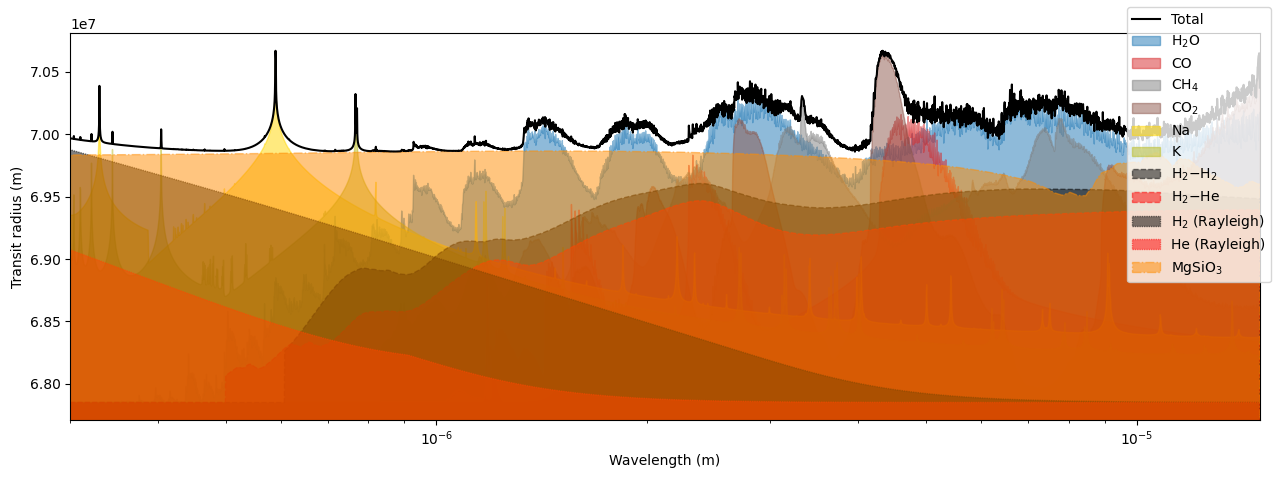

In [16]:
opacity_contributions = plot_opacity_contributions(
    spectral_model,
    mode='transmission',
    fill_below=True,
    x_axis_scale='log'
)

## Plotting opacities

pRT can also be used to plot opacities. For this we can use the `plot_radtrans_opacities()` method, which we import here:

In [17]:
from petitRADTRANS.plotlib import plot_radtrans_opacities

Next we plot the line opacities of the Radtrans object called `atmosphere` created above. This will assume (equal) abundances of 1 for the different species. Chemical equilibrium abundances are also possible, see below. Here we plot all line species of the Radtrans object, but also a subset of them is possible. Just give a list, for example `['H2O', 'CO-NatAbund']`, instead of `atmosphere.line_species`, to the function. If you initialized your Radtrans object with `line_opacity_mode='lbl'` it will plot the high resolution opacities. For the default `line_opacity_mode='c-k'` it will plot the frequency-averaged opacities within the correlated-k frequency bins, like defined here for frequency bin $i$:
$$
\bar{\kappa}_i = \frac{1}{\Delta \nu_i} \int_{\nu_i - \Delta \nu_i/2}^{\nu_i + \Delta \nu_i / 2} \kappa(\nu)d\nu = \int_0^1 \kappa_i(g)dg
$$

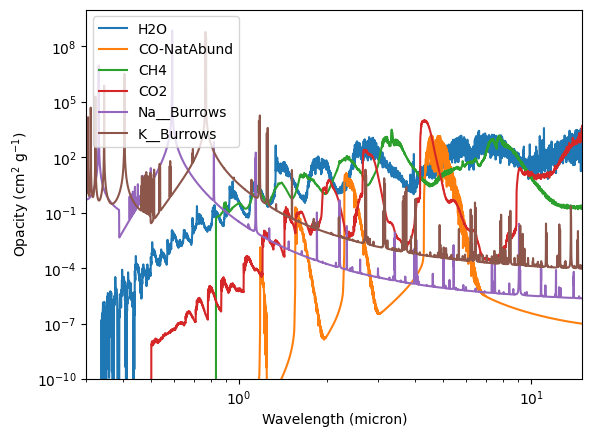

In [18]:
plot_radtrans_opacities(
    atmosphere,
    atmosphere.line_species,
    temperature=1500.0,
    pressure_bar=0.1
)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e10])
plt.xlim([0.3,15.])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

<div class="alert alert-info">

`SpectalModel` objects are also `Radtrans` objects, so they can be used with `plot_radtrans_opacities`, e.g.:
```python
plot_radtrans_opacities(
    spectral_model,
    spectral_model.line_species,
    temperature=1500.,
    pressure_bar=0.1
)
```
</div>

You can also use chemical equilibrium abundances for the relative weighting, here at C/O=0.55 (solar) and metallicity of 0 (solar).
Not that it will notify you if it does not find a given species from `atmosphere.line_species` in the chemical abundance dictionary exactly, for example it will use the `CO` abundance for `CO-NatAbund`, etc.

Loading chemical equilibrium chemistry table from file '/home/dblain/petitRADTRANS/input_data/pre_calculated_chemistry/equilibrium_chemistry/equilibrium_chemistry.chemtable.petitRADTRANS.h5'... Done.


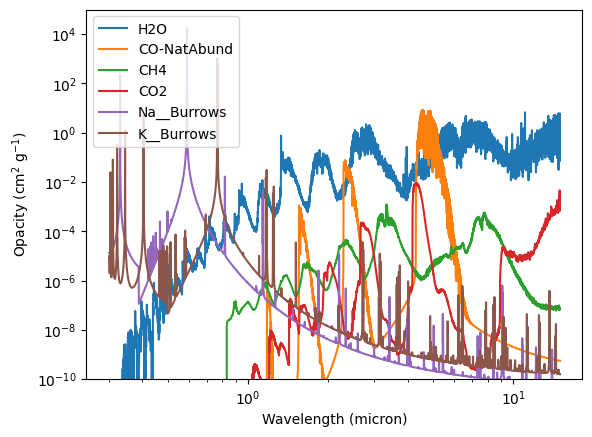

In [19]:
plot_radtrans_opacities(
    atmosphere,
    atmosphere.line_species,
    temperature=1500.0,
    pressure_bar=0.1,
    co_ratio=0.55,
    log10_metallicity=0.,
    mass_fractions='eq'
)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e5])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

Or you choose the mass fractions of the absorber yourself. Note that ``plot_opas`` also supports all keyword arguments of ``matplotlib.plot()`` (here we use ``linestyle`` as an example).

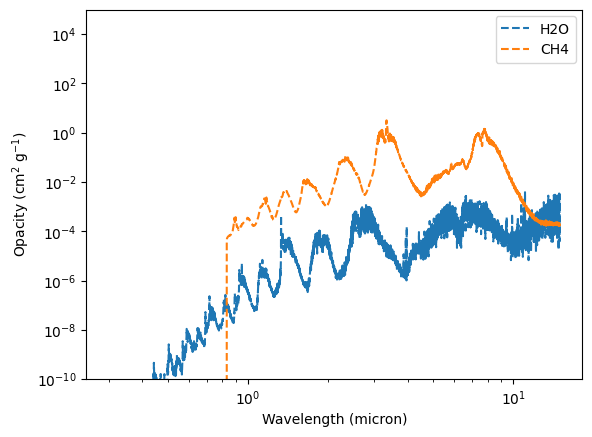

In [20]:
mass_fractions = {}
mass_fractions['H2O'] = 1e-6
mass_fractions['CH4'] = 1e-3

plot_radtrans_opacities(
    atmosphere,
    ['H2O', 'CH4'],
    temperature=1500.0,
    pressure_bar=0.1,
    mass_fractions=mass_fractions,
    linestyle = '--'
)

plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e5])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

If you set `return_opacities=True` it will return a dictionary with wavelengths and opacities for the various line absorbers you request, instead of plotting them. Then you can make a plot yourself (or other things)...

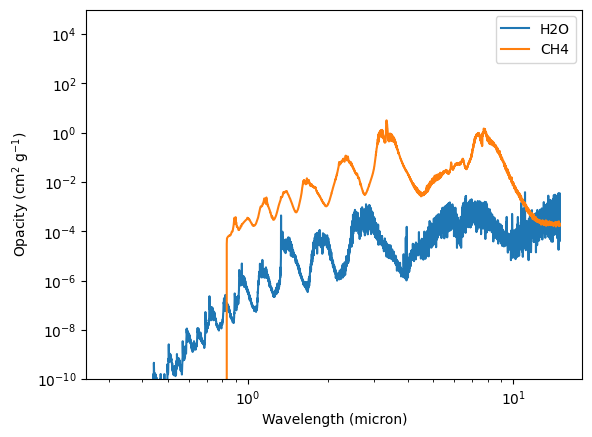

In [21]:
opacities = plot_radtrans_opacities(
    atmosphere,
    ['H2O', 'CH4'],
    temperature=1500.0,
    pressure_bar=0.1,
    mass_fractions=mass_fractions,
    return_opacities=True
)

for species in opacities.keys():
    plt.plot(opacities[species][0], opacities[species][1], label=species)
             
plt.yscale('log')
plt.xscale('log')
plt.ylim([1e-10,1e5])
plt.ylabel('Opacity (cm$^2$ g$^{-1}$)')
plt.xlabel('Wavelength (micron)')
plt.legend()

## Getting mettalicity and elemental abundances from mass fractions

In petitRADTRANS, it is possible to get a first, rough estimate of metallicity and element-over-hydrogen ratios using the `mass_fractions2metallicity` function.

<div class="alert alert-info">

The output is in regular scale, not in log scale.
</div>

<div class="alert alert-info">

An alternative function using volume mixing ratios,`volume_mixing_ratios2metallicity`, is also available.
</div>

<div class="alert alert-warning">

The function estimates the metallicity from the given mass fraction dict. Elements and species not present in the mass fraction dict (but maybe present in an actual atmosphere) will not be accounted for, hence the results are necessarily a **lower estimate** of the actual atmospheric metallicity. 

As with any metallicity obtained from atmospheric composition, the results are representative of the part of the atmosphere from which the species abundances have been inferred. It is **not** an estimation of the planet's bulk metallicity, which would account for the metals in the core and deep atmosphere.
</div>

In [22]:
from petitRADTRANS.chemistry.utils import mass_fractions2metallicity

In [23]:
# The generated SpectralModel is used to have an atmospheric composition in which tbe sum of all mass fractions is 1
metallicity, h_ratios = mass_fractions2metallicity(spectral_model.mass_fractions, spectral_model.mean_molar_masses)

print(f"Z = {np.mean(metallicity):.2f} solar")

for dictionary in h_ratios.values():
    print(f"{dictionary['description']} = {np.mean(dictionary['relative to solar']):.2f} solar")

Z = 0.90 solar
He/H = 0.97 solar
C/H = 1.63 solar
O/H = 1.04 solar
Na/H = 3.13 solar
Mg/H = 0.00 solar
Si/H = 0.00 solar
K/H = 0.29 solar
